# Analysing Characteristics of an entire PageXML Archive

**Note**: This tutorial follows and depends on the tutorial on [Reading PageXML files from archives](./Demo-reading-pagexml-files-from-archive.ipynb). It assumes you have downloaded the PageXML archives and derived line format files from them. 

This tutorials shows how you can analyse the layout and text of sets of PageXML files.

As an example of a zipped archive, this tutorial uses two datasets provided by the [National Archives of the Netherlands](https://www.nationaalarchief.nl/en) (NA) via their HTR repository on [Zenodo](https://zenodo.org/): https://zenodo.org/record/6414086#.Y8Elk-zMIUo. The repository contains many other HTR PageXML datasets that NA made available.

The datasets contains HTR output in [PageXML](https://www.primaresearch.org/tools/PAGELibraries) format of scans from the following archive: 
- (small) _Notaris mr. D.A.M.de Fremery te Assen, 1899-1915, 114.11, 1_ ([EAD](https://www.drentsarchief.nl/onderzoeken/archiefstukken?mivast=34&mizig=210&miadt=34&micode=0114.11&miview=inv2)). This is an archive maintained by the [Drents Archief](https://www.drentsarchief.nl).
- (medium) _Verspreide West-Indische stukken, 1614-1875, 1.05.06, 1-1413_ ([EAD](https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/%401?query=1.05.06&search-type=inventory)). This is an archive maintained by the [Nationaal Archief](https://www.nationaalarchief.nl/en). 

You can download the datasets via the following URLs:
- https://zenodo.org/record/6414086/files/HTR%20results%20DA%200114.11%20PAGE.zip?download=1
- https://zenodo.org/record/6414086/files/HTR%20results%201.05.06%20PAGE.zip?download=1


In [1]:
%reload_ext autoreload
%autoreload 2


## Extracting PageXML files from Zip/Tar files

The example zip files contains of smaller zip files, that each have a number of PageXML files. 

In [136]:
import json

import matplotlib.pyplot as plt

from pagexml.analysis.stats import get_doc_stats
from pagexml.helper.file_helper import read_page_archive_files
from pagexml.parser import parse_pagexml_files_from_archive

da_archive_file = '../data/HTR results DA 0114.11 PAGE.zip'
na_archive_file = '../data/HTR results 1.05.06 PAGE.zip'

parse_pagexml_files_from_archive(na_archive_file)


<generator object parse_pagexml_files_from_archive at 0x10360a110>

# Analysing documents based on layout

## Categorising lines by their widths

Lines can vary strongly in how much text they contain, from one or a few characters to a dozen or more words. How much text they contain and how large the characters are, are related to a line's width. 

The distribution of the width of text lines can tell us whether most lines are roughly of similar length, of whether there are different clusters of line widths. Based on these _line width_ clusters, we can cluster scans based on their distribution of line widths, which can help us identify different types of scans. 

We start with an analysis of the distribution of line widths. Scans often have a width of several thousand pixels, with individual characters taking up somewhere between 15 and 150 pixels. 

In [3]:
%%time
import seaborn as sns

import pagexml.analysis.layout_stats as layout_stats
from pagexml.parser import parse_pagexml_files_from_archive
from pagexml.helper.text_helper import read_pagexml_docs_from_line_file

sns.set_theme()

da_line_file = '../data/line_format-NL-AsnDA_0114.11.tsv.gz'
na_line_file = '../data/line_format-NL-HaNA_1.05.06.tsv.gz'

# reading from line file is much faster 
# than reading from archived PageXML files
scans = read_pagexml_docs_from_line_file(na_line_file, add_bounding_box=True)


line_bin_size = 100
line_widths = layout_stats.get_line_widths(scans, line_bin_size)
print(f'Number of lines: {len(line_widths)}')

Number of lines: 1007175
CPU times: user 17.3 s, sys: 102 ms, total: 17.4 s
Wall time: 17.4 s


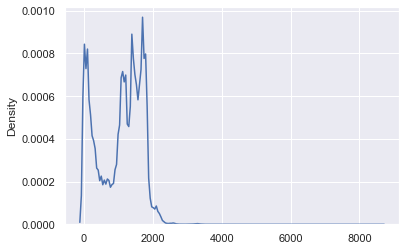

In [4]:
sns.kdeplot(data=line_widths);

We can use the local maxima as centroids of clusters of lines with similar width, and the local minima as boundary points between these clusters. That way, we can categorise the lines of a scan according to these clusters and get summary statistics per scan on the categories of line widths.

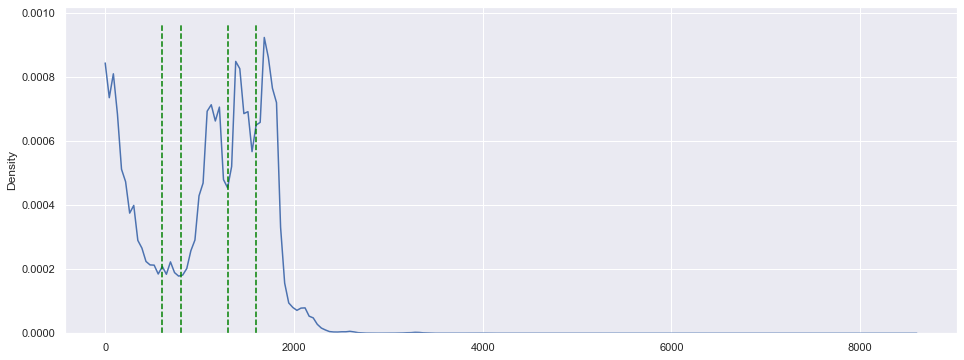

In [28]:
from demo_scripts import plot_line_widths_boundary_points

boundary_points = layout_stats.find_line_width_boundary_points(line_widths, line_bin_size)

plot_line_widths_boundary_points(line_widths, boundary_points)

The distribution has several peaks and valleys. The valleys can be used as boundary points between categories of lines.

# Collecting document statistics

It's simple to get some statistics on the text on a scan using the `.stats` property. But this is very minimal. 

In [139]:
scans = parse_pagexml_files_from_archive(na_archive_file)

for si, scan in enumerate(scans):
    print(scan.id, scan.stats)
    if (si+1) > 5:
        break

NL-HaNA_1.05.06_1_0001.jpg {'lines': 33, 'words': 165, 'text_regions': 1, 'columns': 0, 'extra': 0, 'pages': 0}
NL-HaNA_1.05.06_1_0002.jpg {'lines': 59, 'words': 286, 'text_regions': 2, 'columns': 0, 'extra': 0, 'pages': 0}
NL-HaNA_1.05.06_1_0003.jpg {'lines': 54, 'words': 263, 'text_regions': 2, 'columns': 0, 'extra': 0, 'pages': 0}
NL-HaNA_1.05.06_1_0004.jpg {'lines': 0, 'words': 0, 'text_regions': 0, 'columns': 0, 'extra': 0, 'pages': 0}
NL-HaNA_1.05.06_1_0005.jpg {'lines': 0, 'words': 0, 'text_regions': 0, 'columns': 0, 'extra': 0, 'pages': 0}
NL-HaNA_1.05.06_10_0001.jpg {'lines': 34, 'words': 254, 'text_regions': 2, 'columns': 0, 'extra': 0, 'pages': 0}


## Gathering descriptive statistics per scan

The `pagexml.analysis.stats` module contains a function called `get_doc_stats` that gives a richer set of statistics. You can pass it a set of scans (as an iterable, so it can also be an iterable that reads scans from file) to calculate basic statistics per scan, such as:

- the number of lines and words,
- the nubmer of lines of different line width categories,
- the number of words that start with an uppercase character,
- the number of words that are numbers,
- the number of words binned by their lengths.

These allow simple analysis of sequences of scans and cluster of scans based on these characteristics. This is a low-resource approach to clustering and classifying documents. 

**Note**: don't use line-format files for gathering statistics per scan, because line-format files only capture scans that contain at least one text line. **In other words, empty scans are not in the line-format files, and therefore will not be represented in scan statistics!**

In [278]:
import pagexml.analysis.text_stats as text_stats

scans = parse_pagexml_files_from_archive(na_archive_file)

scans_stats = []

scans_stats = get_doc_stats(scans, line_width_boundary_points=boundary_points)
  

In [279]:
import pandas as pd

df = pd.DataFrame(scans_stats)

print(df.shape)

df.head(5)

(15857, 39)


,doc_id,doc_num,doc_width,doc_height,lines,words,text_regions,columns,extra,pages,...,num_words_length_10,num_words_length_15,num_words_length_20,num_words_length_25,num_words_length_30,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-
0,NL-HaNA_1.05.06_1_0001.jpg,1,2522,3957,33,165,1,0,0,0,...,59,17,0,0,0,4,0,2,0,27
1,NL-HaNA_1.05.06_1_0002.jpg,2,4861,3963,59,286,2,0,0,0,...,134,17,0,0,0,3,0,0,2,54
2,NL-HaNA_1.05.06_1_0003.jpg,3,4886,3960,54,263,2,0,0,0,...,103,26,0,0,0,2,0,4,1,47
3,NL-HaNA_1.05.06_1_0004.jpg,4,4882,3955,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NL-HaNA_1.05.06_1_0005.jpg,5,2493,3964,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Grouping scans by inventory

The archive contains 15,857 scans belonging to 533 inventories. We use the document identifier to add information per scan on the inventory number and the sequence number of the scan in the inventory's list of scans.

Once we have added this inventory and sequence information, we can:

- group scans by inventory and compare inventories on aggregate statistics,
- visualise characteristics of scans per inventory in sequence order.

In [280]:
df['archive_id'] = df.doc_id.apply(lambda x: x.split('_')[1])
df['inv_num'] = df.doc_id.apply(lambda x: x.split('_')[2])
df['scan_num'] = df.doc_id.apply(lambda x: int(x.split('_')[3].replace('.jpg', '')))
s_inv_nums = df.inv_num.value_counts()
df['num_scans'] = df.inv_num.apply(lambda x: s_inv_nums.loc[x])
df = df.sort_values(['inv_num', 'scan_num'])
df

,doc_id,doc_num,doc_width,doc_height,lines,words,text_regions,columns,extra,pages,...,num_words_length_30,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,archive_id,inv_num,scan_num,num_scans
0,NL-HaNA_1.05.06_1_0001.jpg,1,2522,3957,33,165,1,0,0,0,...,0,4,0,2,0,27,1.05.06,1,1,5
1,NL-HaNA_1.05.06_1_0002.jpg,2,4861,3963,59,286,2,0,0,0,...,0,3,0,0,2,54,1.05.06,1,2,5
2,NL-HaNA_1.05.06_1_0003.jpg,3,4886,3960,54,263,2,0,0,0,...,0,2,0,4,1,47,1.05.06,1,3,5
3,NL-HaNA_1.05.06_1_0004.jpg,4,4882,3955,0,0,0,0,0,0,...,0,0,0,0,0,0,1.05.06,1,4,5
4,NL-HaNA_1.05.06_1_0005.jpg,5,2493,3964,0,0,0,0,0,0,...,0,0,0,0,0,0,1.05.06,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15852,NL-HaNA_1.05.06_99_0036.jpg,15853,5103,4067,46,265,3,0,0,0,...,0,6,0,3,1,35,1.05.06,99,36,40
15853,NL-HaNA_1.05.06_99_0037.jpg,15854,5125,4065,44,297,3,0,0,0,...,0,4,0,1,0,39,1.05.06,99,37,40
15854,NL-HaNA_1.05.06_99_0038.jpg,15855,5116,4104,44,290,3,0,0,0,...,0,4,1,4,2,33,1.05.06,99,38,40
15855,NL-HaNA_1.05.06_99_0039.jpg,15856,5111,4054,44,252,3,0,0,0,...,0,7,3,3,1,30,1.05.06,99,39,40


In [281]:
df.head(10)

,doc_id,doc_num,doc_width,doc_height,lines,words,text_regions,columns,extra,pages,...,num_words_length_30,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,archive_id,inv_num,scan_num,num_scans
0,NL-HaNA_1.05.06_1_0001.jpg,1,2522,3957,33,165,1,0,0,0,...,0,4,0,2,0,27,1.05.06,1,1,5
1,NL-HaNA_1.05.06_1_0002.jpg,2,4861,3963,59,286,2,0,0,0,...,0,3,0,0,2,54,1.05.06,1,2,5
2,NL-HaNA_1.05.06_1_0003.jpg,3,4886,3960,54,263,2,0,0,0,...,0,2,0,4,1,47,1.05.06,1,3,5
3,NL-HaNA_1.05.06_1_0004.jpg,4,4882,3955,0,0,0,0,0,0,...,0,0,0,0,0,0,1.05.06,1,4,5
4,NL-HaNA_1.05.06_1_0005.jpg,5,2493,3964,0,0,0,0,0,0,...,0,0,0,0,0,0,1.05.06,1,5,5
5,NL-HaNA_1.05.06_10_0001.jpg,6,2622,4011,34,254,2,0,0,0,...,0,1,1,4,1,26,1.05.06,10,1,53
6,NL-HaNA_1.05.06_10_0002.jpg,7,5135,4010,67,519,3,0,0,0,...,0,4,0,1,3,58,1.05.06,10,2,53
7,NL-HaNA_1.05.06_10_0003.jpg,8,5141,4008,70,546,4,0,0,0,...,0,6,0,0,0,62,1.05.06,10,3,53
8,NL-HaNA_1.05.06_10_0004.jpg,9,5140,4010,70,559,2,0,0,0,...,0,5,0,0,1,63,1.05.06,10,4,53
9,NL-HaNA_1.05.06_10_0005.jpg,10,5137,4007,71,548,3,0,0,0,...,0,5,0,2,0,64,1.05.06,10,5,53


The number of scans per inventory is a heavily skewed distribution. Most inventories have only a handful of scans.

### Viewing scans

Because the scans of this archive are also viewable online, we can make visual checks of scans. The scan identifier allows us to construct a viewer URL:

In [282]:
# https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0001?eadID=1.05.06&unitID=1&query=1.05.06
def make_iiif_url(row):
    base_url = 'https://www.nationaalarchief.nl/onderzoeken/archief'
    return f"{base_url}/{row['archive_id']}/invnr/{row['inv_num']}/file/{row['doc_id'][:-4]}?eadId={row['archive_id']}&unitID={row['inv_num']}"


def make_clickable(val):
    return f'<a target="_blank" href="{val}">{val}</a>'



df['iiif_url'] = df.apply(lambda row: make_iiif_url(row), axis=1)
df[['doc_id', 'iiif_url']].head(10).style.format({'iiif_url': make_clickable})


,doc_id,iiif_url
0,NL-HaNA_1.05.06_1_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0001?eadId=1.05.06&unitID=1
1,NL-HaNA_1.05.06_1_0002.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0002?eadId=1.05.06&unitID=1
2,NL-HaNA_1.05.06_1_0003.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0003?eadId=1.05.06&unitID=1
3,NL-HaNA_1.05.06_1_0004.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0004?eadId=1.05.06&unitID=1
4,NL-HaNA_1.05.06_1_0005.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0005?eadId=1.05.06&unitID=1
5,NL-HaNA_1.05.06_10_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0001?eadId=1.05.06&unitID=10
6,NL-HaNA_1.05.06_10_0002.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0002?eadId=1.05.06&unitID=10
7,NL-HaNA_1.05.06_10_0003.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0003?eadId=1.05.06&unitID=10
8,NL-HaNA_1.05.06_10_0004.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0004?eadId=1.05.06&unitID=10
9,NL-HaNA_1.05.06_10_0005.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0005?eadId=1.05.06&unitID=10


### Writing stats to file

Now that statistics of more than 14,000 scans have been calculated and various columns have been added, it is worthwhile writing the statistics to file, so they can be re-used in other analyses, e.g.:

- [book section detection](./Demo-analysing-scan-characteristics-book-sections.ipynb)
- [comparing subsets](./Demo-analysing-scan-characteristics-comparing-subsets.ipynb)
- [checking quality](./Demo-analysing-scan-characteristics-checking-quality.ipynb)


In [283]:
stats_file = '../data/na_scan_stats.tsv.gz'

df.to_csv(stats_file, sep='\t', compression='gzip', index=False)

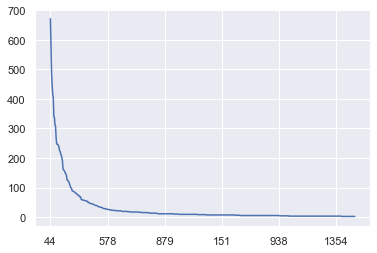

In [30]:
df.inv_num.value_counts().plot();

## Comparing size and shape of scans

### Width and height of scans

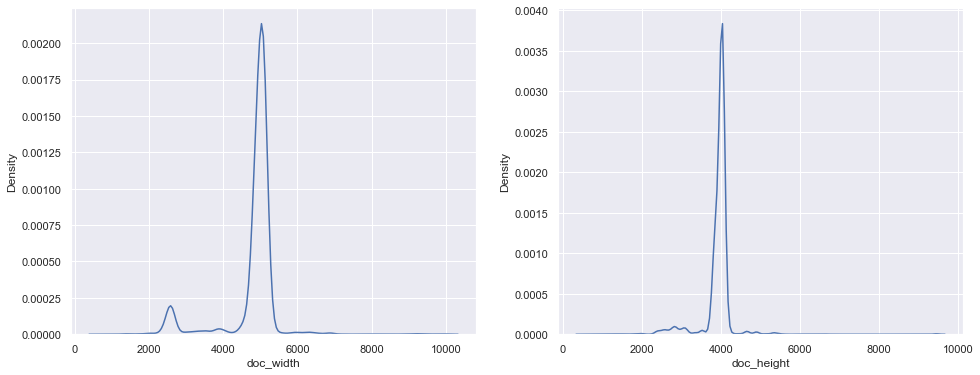

In [229]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

sns.kdeplot(data=df.doc_width, ax=ax[0]);
sns.kdeplot(data=df.doc_height, ax=ax[1]);
fig.set_size_inches(16, 6)

In [234]:
df.doc_width.value_counts()
data = ax[0].lines[0].get_xydata()
peak_width = data[np.where(data[:, 1] == max(data[:, 1]))][0][0]
data = ax[1].lines[0].get_xydata()
peak_height = data[np.where(data[:, 1] == max(data[:, 1]))][0][0]
peak_width, peak_height

(5030.511794106549, 4044.1712745763934)

The vast majority of scans are roughly the same shape, with a width around 5000 pixels and a height around 4000 pixels. There are a few bumps at other widths and heights.

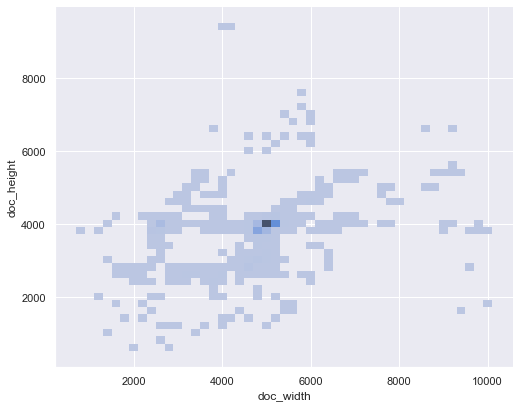

In [227]:
ax = sns.displot(data=df, x='doc_width', y='doc_height', binwidth=(200, 200));
ax.figure.set_size_inches(8, 6)

There seem to be some small clusters of pages with different sizes:

- smaller documents with both a lower width and height than 5000 by 4000
- bigger documents with both a higher width and height than 5000 by 4000
- wider and narrower documents with a height around 4000 but lower or higher width than 5000

If we plot the ratio of width to height, we can see the distribution of scans that are roughly shaped as _landscape_, _portrait_ or _square_.

### Shape of scans

<Axes: ylabel='Density'>

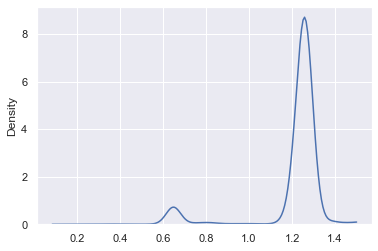

In [209]:
sns.kdeplot(data=df.doc_width.div(df.doc_height, axis=0), clip=(0,1.5))

We use this information to classify scan shape and scan sizes.

### Classifying scans by shape, width and height

In [236]:
def classify_scan_width(width, peak_width):
    if width / peak_width < 0.9:
        return 'narrow'
    elif width / peak_width > 1.1:
        return 'wide'
    else:
        return 'medium'


def classify_scan_height(height, peak_height):
    if height / peak_height < 0.9:
        return 'high'
    elif height / peak_height > 1.1:
        return 'low'
    else:
        return 'medium'


def classify_scan_shape(row):
    if row['doc_width'] / row['doc_height'] > 1.1:
        return 'landscape'
    if row['doc_width'] / row['doc_height'] < 0.9:
        return 'portrait'
    else:
        return 'square'
    
df['shape_class'] = df.apply(classify_scan_shape, axis=1)
df['width_class'] = df.doc_width.apply(lambda width: classify_scan_width(width, peak_width))
df['height_class'] = df.doc_height.apply(lambda height: classify_scan_width(height, peak_height))

df

,doc_id,doc_num,doc_width,doc_height,lines,words,text_regions,columns,extra,pages,...,wpl_few,wpl_many,archive_id,inv_num,scan_num,num_scans,scan_shape,shape_class,width_class,height_class
0,NL-HaNA_1.05.06_1_0001.jpg,1,2522,3957,33,165,1,0,0,0,...,5,28,1.05.06,1,1,5,portrait,portrait,narrow,medium
1,NL-HaNA_1.05.06_1_0002.jpg,2,4861,3963,59,286,2,0,0,0,...,5,54,1.05.06,1,2,5,landscape,landscape,medium,medium
2,NL-HaNA_1.05.06_1_0003.jpg,3,4886,3960,54,263,2,0,0,0,...,3,51,1.05.06,1,3,5,landscape,landscape,medium,medium
3,NL-HaNA_1.05.06_1_0004.jpg,4,4882,3955,0,0,0,0,0,0,...,0,0,1.05.06,1,4,5,landscape,landscape,medium,medium
4,NL-HaNA_1.05.06_1_0005.jpg,5,2493,3964,0,0,0,0,0,0,...,0,0,1.05.06,1,5,5,portrait,portrait,narrow,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15852,NL-HaNA_1.05.06_99_0036.jpg,15853,5103,4067,46,265,3,0,0,0,...,9,36,1.05.06,99,36,40,landscape,landscape,medium,medium
15853,NL-HaNA_1.05.06_99_0037.jpg,15854,5125,4065,44,297,3,0,0,0,...,5,39,1.05.06,99,37,40,landscape,landscape,medium,medium
15854,NL-HaNA_1.05.06_99_0038.jpg,15855,5116,4104,44,290,3,0,0,0,...,5,39,1.05.06,99,38,40,landscape,landscape,medium,medium
15855,NL-HaNA_1.05.06_99_0039.jpg,15856,5111,4054,44,252,3,0,0,0,...,10,34,1.05.06,99,39,40,landscape,landscape,medium,medium


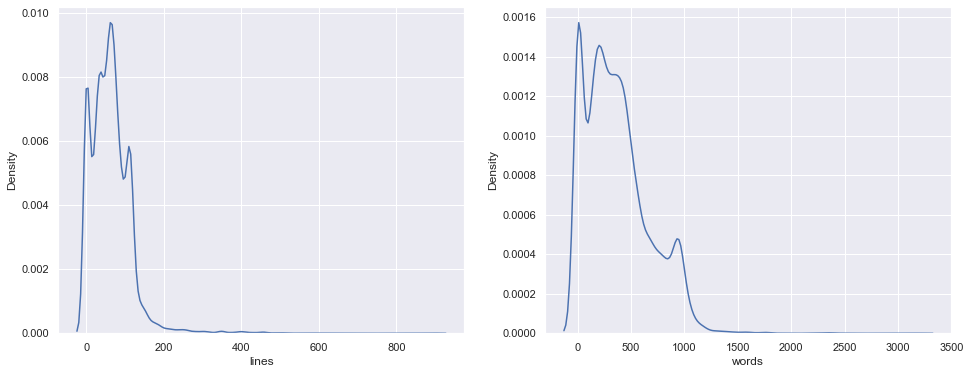

In [239]:
fig, ax = plt.subplots(1, 2)

sns.kdeplot(data=df.lines, ax=ax[0]);
sns.kdeplot(data=df.words, ax=ax[1]);
fig.set_size_inches(16, 6)

### Comparing scans of different shapes

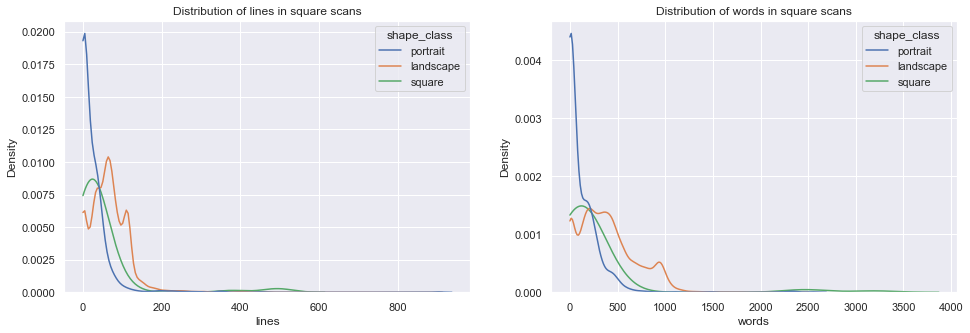

In [268]:
portrait = df[df.shape_class == 'portrait']
landscape = df[df.shape_class == 'landscape']
square = df[df.shape_class == 'square']

fig, ax = plt.subplots(1, 2)

clip_words = (0, 4000)
clip_lines = (0, 1000)

sns.kdeplot(data=df, x='lines', hue='shape_class', common_norm=False, clip=clip_lines, ax=ax[0]);
sns.kdeplot(data=df, x='words', hue='shape_class', common_norm=False, clip=clip_words, ax=ax[1]);

ax[0].set_title('Distribution of lines in scans')
ax[1].set_title('Distribution of words in scans')


fig.set_size_inches(16, 5)

## Analysing scans with many lines and many words

### Scans with high numbers of lines

In [262]:
# sort scans by descending number of lines and show shape information and a clickable viewer URL
(df.sort_values('lines', ascending=False)
 .head(10)[['doc_id', 'lines', 'doc_width', 'doc_height', 'width_class', 'height_class', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,lines,doc_width,doc_height,width_class,height_class,iiif_url
12420,NL-HaNA_1.05.06_709_0006.jpg,904,5165,6145,medium,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/709/file/NL-HaNA_1.05.06_709_0006?eadId=1.05.06&unitID=709
7000,NL-HaNA_1.05.06_176_0002.jpg,890,9934,3844,wide,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/176/file/NL-HaNA_1.05.06_176_0002?eadId=1.05.06&unitID=176
6999,NL-HaNA_1.05.06_176_0001.jpg,788,9705,3864,wide,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/176/file/NL-HaNA_1.05.06_176_0001?eadId=1.05.06&unitID=176
7091,NL-HaNA_1.05.06_186_0015.jpg,704,7857,4948,wide,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/186/file/NL-HaNA_1.05.06_186_0015?eadId=1.05.06&unitID=186
2168,NL-HaNA_1.05.06_117_0043.jpg,690,5026,4010,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/117/file/NL-HaNA_1.05.06_117_0043?eadId=1.05.06&unitID=117
7253,NL-HaNA_1.05.06_220_0005.jpg,660,5102,4085,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/220/file/NL-HaNA_1.05.06_220_0005?eadId=1.05.06&unitID=220
1310,NL-HaNA_1.05.06_1166_0293.jpg,636,5058,4036,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1166/file/NL-HaNA_1.05.06_1166_0293?eadId=1.05.06&unitID=1166
7251,NL-HaNA_1.05.06_220_0003.jpg,620,5126,4107,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/220/file/NL-HaNA_1.05.06_220_0003?eadId=1.05.06&unitID=220
7252,NL-HaNA_1.05.06_220_0004.jpg,604,5128,4104,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/220/file/NL-HaNA_1.05.06_220_0004?eadId=1.05.06&unitID=220
7128,NL-HaNA_1.05.06_213_0002.jpg,585,5064,4012,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/213/file/NL-HaNA_1.05.06_213_0002?eadId=1.05.06&unitID=213


Many of the scans with a high number of lines contain lists and tables. Each cell in the table is represented by a separate line, which is mostly short. **In this archive, a high number of lines per scan seems to signal that the scan represents a table**.


### Scans with high numbers of words

In [269]:
# sort scans by descending number of words and show shape information and a clickable viewer URL
(df.sort_values('words', ascending=False)
 .head(10)[['doc_id', 'lines', 'words', 'doc_width', 'doc_height', 'width_class', 'height_class', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,lines,words,doc_width,doc_height,width_class,height_class,iiif_url
4542,NL-HaNA_1.05.06_1200_0003.jpg,502,3198,5987,6356,wide,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1200/file/NL-HaNA_1.05.06_1200_0003?eadId=1.05.06&unitID=1200
3196,NL-HaNA_1.05.06_1174_0207.jpg,228,2538,3392,5424,narrow,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1174/file/NL-HaNA_1.05.06_1174_0207?eadId=1.05.06&unitID=1174
4541,NL-HaNA_1.05.06_1200_0002.jpg,487,2534,5987,6343,wide,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1200/file/NL-HaNA_1.05.06_1200_0002?eadId=1.05.06&unitID=1200
4540,NL-HaNA_1.05.06_1200_0001.jpg,377,2402,5847,6339,wide,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1200/file/NL-HaNA_1.05.06_1200_0001?eadId=1.05.06&unitID=1200
11545,NL-HaNA_1.05.06_56_0016.jpg,253,2377,5101,4053,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/56/file/NL-HaNA_1.05.06_56_0016?eadId=1.05.06&unitID=56
4543,NL-HaNA_1.05.06_1200_0004.jpg,344,2357,4662,6375,medium,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1200/file/NL-HaNA_1.05.06_1200_0004?eadId=1.05.06&unitID=1200
8111,NL-HaNA_1.05.06_327_0004.jpg,189,2346,3187,5048,narrow,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/327/file/NL-HaNA_1.05.06_327_0004?eadId=1.05.06&unitID=327
3195,NL-HaNA_1.05.06_1174_0206.jpg,223,2304,3377,5421,narrow,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1174/file/NL-HaNA_1.05.06_1174_0206?eadId=1.05.06&unitID=1174
11540,NL-HaNA_1.05.06_56_0011.jpg,185,2270,5082,4047,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/56/file/NL-HaNA_1.05.06_56_0011?eadId=1.05.06&unitID=56
8110,NL-HaNA_1.05.06_327_0003.jpg,286,2180,3193,5053,narrow,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/327/file/NL-HaNA_1.05.06_327_0003?eadId=1.05.06&unitID=327


**Inventories with a high median number of words per page are mostly printed material.** They seem to be a mixture of patents (NL: 'Octrooi'), newspapers and lists/tables.

## Categorising scans by number of words per line

**Assumptions**: 
- many lines with few words (3 or fewer) signals the table contains a table or list
- many lines with several words (4 or more) signals the table contains a running text.

**TO DO**:
- It probably works better after some further pre-processing, e.g. 
    - calculate these statistics per text region and classify text regions,
    - cut scans into pages and classify individual pages. A two-page scan (the majority of scans?) can have a full-text page and a table/list or empty page.

In [271]:
wpl_cols = [col for col in df.columns if 'words_per_line_' in col]
wpl_cols

['words_per_line_0-0',
 'words_per_line_1-1',
 'words_per_line_2-2',
 'words_per_line_3-3',
 'words_per_line_4-5',
 'words_per_line_6-9',
 'words_per_line_10-15',
 'words_per_line_16-25',
 'words_per_line_26-42',
 'words_per_line_43-70',
 'words_per_line_71-100']

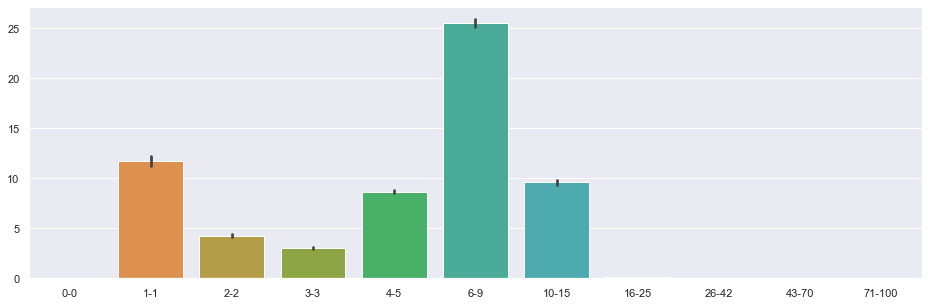

In [277]:
ax = sns.barplot(data=df[wpl_cols].rename(columns={col: col.replace('words_per_line_', '') for col in wpl_cols}))
ax.figure.set_size_inches(16,5)

In [197]:
wpl_few_cols = [col for col in wpl_cols if int(col.split('-')[-1]) <= 3]
wpl_many_cols = [col for col in wpl_cols if int(col.split('-')[-1]) > 3]
wpl_few_cols, wpl_many_cols

df['wpl_few'] = df[wpl_few_cols].sum(axis=1)
df['wpl_many'] = df[wpl_many_cols].sum(axis=1)


In [200]:
wpl_rel_df = df[['wpl_few', 'wpl_many']].div(df.lines, axis=0)
wpl_rel_df['lines'] = df.lines
wpl_rel_df

,wpl_few,wpl_many,lines
0,0.151515,0.848485,33
1,0.084746,0.915254,59
2,0.055556,0.944444,54
3,NaN,NaN,0
4,NaN,NaN,0
...,...,...,...
15852,0.195652,0.782609,46
15853,0.113636,0.886364,44
15854,0.113636,0.886364,44
15855,0.227273,0.772727,44


In [203]:
def classify_wpl_scan_type(row):
    if row['lines'] < 10:
        return 'partially_empty'
    elif row['wpl_few'] > 0.7:
        if row['lines'] > 100:
            return 'table'
        else:
            return 'list'
    elif row['wpl_few'] < 0.3:
        return 'running_text'
    else:
        return 'mixed'
    
    
wpl_rel_df['wpl_class'] = wpl_rel_df.apply(classify_wpl_scan_type, axis=1)
wpl_rel_df

,wpl_few,wpl_many,lines,wpl_class
0,0.151515,0.848485,33,running_text
1,0.084746,0.915254,59,running_text
2,0.055556,0.944444,54,running_text
3,NaN,NaN,0,partially_empty
4,NaN,NaN,0,partially_empty
...,...,...,...,...
15852,0.195652,0.782609,46,running_text
15853,0.113636,0.886364,44,running_text
15854,0.113636,0.886364,44,running_text
15855,0.227273,0.772727,44,running_text


In [204]:
wpl_rel_df.wpl_class.value_counts()

running_text       9739
mixed              2697
partially_empty    2390
list                523
table               508
Name: wpl_class, dtype: int64

## Grouping inventories by line categories

In [45]:
lwr_cols = [col for col in df.columns if 'line_width_range_' in col]
df[lwr_cols]

,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-
0,4,0,2,0,27
1,3,0,0,2,54
2,2,0,4,1,47
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
15852,6,0,3,1,35
15853,4,0,1,0,39
15854,4,1,4,2,33
15855,7,3,3,1,30


In [47]:
df.groupby('inv_num')['line_width_range_0-600'].describe().sort_values('50%')

,count,mean,std,min,25%,50%,75%,max
inv_num,,,,,,,,
108A,3.0,1.333333,2.309401,0.0,0.00,0.0,2.00,4.0
946,4.0,2.250000,4.500000,0.0,0.00,0.0,2.25,9.0
37,3.0,0.666667,1.154701,0.0,0.00,0.0,1.00,2.0
47B,3.0,0.333333,0.577350,0.0,0.00,0.0,0.50,1.0
933,3.0,16.666667,28.867513,0.0,0.00,0.0,25.00,50.0
...,...,...,...,...,...,...,...,...
156,7.0,203.714286,138.431348,1.0,132.50,276.0,289.50,305.0
176,4.0,306.750000,354.915365,0.0,0.00,293.0,599.75,641.0
150,28.0,327.321429,141.682235,0.0,325.25,382.0,400.25,448.0


In [51]:
#g = df.groupby('inv_num')[lwr_cols].describe()#.sort_values('50%')
g.swaplevel(0, 1, axis=1)['50%']

,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-
inv_num,,,,,
1,2.0,0.0,0.0,0.0,27.0
10,4.0,0.0,1.0,1.0,51.0
100,3.0,2.0,2.0,0.0,2.0
1005,13.0,1.0,3.0,7.5,42.5
1007,3.0,0.0,1.0,1.0,37.0
...,...,...,...,...,...
981,3.0,0.0,1.0,1.0,44.0
983,4.0,1.0,4.0,0.0,2.5
983A,7.0,1.0,2.0,1.0,3.0


In [70]:
g = df.groupby('inv_num')[lwr_cols + ['lines']].sum()
lwr_rel_df = g[lwr_cols].div(g.lines, axis=0)
lwr_rel_df['num_scans'] = s_inv_nums
lwr_rel_df

,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,num_scans
inv_num,,,,,,
1,0.061644,0.000000,0.041096,0.020548,0.876712,5
10,0.080519,0.007506,0.025247,0.016035,0.845786,53
100,0.510638,0.106383,0.234043,0.042553,0.106383,3
1005,0.224906,0.018868,0.089811,0.110189,0.550189,18
1007,0.041558,0.005195,0.041558,0.023377,0.875325,7
...,...,...,...,...,...,...
981,0.080645,0.016129,0.043011,0.032258,0.822581,5
983,0.268902,0.051762,0.356067,0.035485,0.276552,312
983A,0.561142,0.064548,0.098605,0.062601,0.178073,102


In [71]:
lwr_rel_df.sort_values('line_width_range_800-1300', ascending=False).head(10)



,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,num_scans
inv_num,,,,,,
1084,0.036145,0.000000,0.963855,0.000000,0.000000,3
1242,0.028944,0.013025,0.955137,0.000000,0.000000,11
887,0.053763,0.010753,0.935484,0.000000,0.000000,3
353,0.095556,0.004444,0.895556,0.000000,0.000000,9
1153,0.058696,0.013043,0.892391,0.001087,0.030435,19
108A,0.074074,0.037037,0.888889,0.000000,0.000000,3
886,0.000000,0.000000,0.884615,0.000000,0.076923,2
1243,0.099089,0.017084,0.882688,0.001139,0.000000,15
169,0.092527,0.021352,0.882562,0.000000,0.001779,12


In [65]:
line_cat_invs = lwr_rel_df.sort_values('line_width_range_800-1300', ascending=False).head(10).index

(df[df.inv_num.isin(line_cat_invs)]
 .groupby('inv_num')
 .first()[['doc_id', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,iiif_url
inv_num,,
1084,NL-HaNA_1.05.06_1084_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1084/file/NL-HaNA_1.05.06_1084_0001?eadId=1.05.06&unitID=1084
108A,NL-HaNA_1.05.06_108A_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/108A/file/NL-HaNA_1.05.06_108A_0001?eadId=1.05.06&unitID=108A
1153,NL-HaNA_1.05.06_1153_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1153/file/NL-HaNA_1.05.06_1153_0001?eadId=1.05.06&unitID=1153
1242,NL-HaNA_1.05.06_1242_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1242/file/NL-HaNA_1.05.06_1242_0001?eadId=1.05.06&unitID=1242
1243,NL-HaNA_1.05.06_1243_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1243/file/NL-HaNA_1.05.06_1243_0001?eadId=1.05.06&unitID=1243
169,NL-HaNA_1.05.06_169_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/169/file/NL-HaNA_1.05.06_169_0001?eadId=1.05.06&unitID=169
353,NL-HaNA_1.05.06_353_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/353/file/NL-HaNA_1.05.06_353_0001?eadId=1.05.06&unitID=353
886,NL-HaNA_1.05.06_886_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/886/file/NL-HaNA_1.05.06_886_0001?eadId=1.05.06&unitID=886
887,NL-HaNA_1.05.06_887_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/887/file/NL-HaNA_1.05.06_887_0001?eadId=1.05.06&unitID=887


All these books consist mainly of scans with a single text column on the right half of each page. Moreover, these books are all homogeneous in their line widths.

In [74]:
lwr_rel_df.sort_values('line_width_range_0-600', ascending=False).head(10)



,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,num_scans
inv_num,,,,,,
152,0.985079,0.004188,0.002356,0.001309,0.000785,13
114,0.979724,0.000922,0.002765,0.000000,0.002765,5
156,0.974710,0.012303,0.002051,0.000000,0.000000,7
954,0.974106,0.006165,0.007398,0.000000,0.001233,5
113,0.969639,0.011385,0.003795,0.000000,0.007590,5
1401,0.956772,0.020173,0.005764,0.000000,0.008646,3
150,0.954787,0.002917,0.002917,0.001667,0.000625,28
928,0.942973,0.022003,0.014818,0.000898,0.000449,13
220,0.937853,0.050847,0.000628,0.000000,0.001255,9


In [75]:
lwr_rel_df.sort_values('line_width_range_1300-1600', ascending=False).head(10)



,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,num_scans
inv_num,,,,,,
1220,0.074828,0.009166,0.028821,0.885775,0.000000,109
260,0.060261,0.004886,0.047231,0.884365,0.001629,8
1226,0.069069,0.015015,0.045045,0.867868,0.000000,5
1195,0.093750,0.025568,0.022727,0.852273,0.000000,5
24,0.135225,0.035058,0.013356,0.816361,0.000000,7
1193,0.137085,0.041126,0.019481,0.787157,0.012987,15
1197,0.181818,0.017408,0.017408,0.783366,0.000000,9
1148,0.086957,0.086957,0.000000,0.782609,0.043478,2
399,0.135965,0.028509,0.059211,0.774123,0.000000,7


In [76]:
line_cat_invs = lwr_rel_df.sort_values('line_width_range_1300-1600', ascending=False).head(10).index

(df[df.inv_num.isin(line_cat_invs)]
 .groupby('inv_num')
 .first()[['doc_id', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,iiif_url
inv_num,,
1148,NL-HaNA_1.05.06_1148_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1148/file/NL-HaNA_1.05.06_1148_0001?eadId=1.05.06&unitID=1148
1193,NL-HaNA_1.05.06_1193_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1193/file/NL-HaNA_1.05.06_1193_0001?eadId=1.05.06&unitID=1193
1195,NL-HaNA_1.05.06_1195_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1195/file/NL-HaNA_1.05.06_1195_0001?eadId=1.05.06&unitID=1195
1197,NL-HaNA_1.05.06_1197_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1197/file/NL-HaNA_1.05.06_1197_0001?eadId=1.05.06&unitID=1197
120,NL-HaNA_1.05.06_120_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/120/file/NL-HaNA_1.05.06_120_0001?eadId=1.05.06&unitID=120
1220,NL-HaNA_1.05.06_1220_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1220/file/NL-HaNA_1.05.06_1220_0001?eadId=1.05.06&unitID=1220
1226,NL-HaNA_1.05.06_1226_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1226/file/NL-HaNA_1.05.06_1226_0001?eadId=1.05.06&unitID=1226
24,NL-HaNA_1.05.06_24_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/24/file/NL-HaNA_1.05.06_24_0001?eadId=1.05.06&unitID=24
260,NL-HaNA_1.05.06_260_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/260/file/NL-HaNA_1.05.06_260_0001?eadId=1.05.06&unitID=260


In [72]:
lwr_rel_df.sort_values('line_width_range_600-800', ascending=False).head(10)



,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,num_scans
inv_num,,,,,,
315,0.090909,0.272727,0.363636,0.181818,0.090909,3
109,0.200000,0.233333,0.066667,0.066667,0.433333,3
1367,0.111111,0.222222,0.111111,0.000000,0.555556,2
314,0.419890,0.220994,0.243094,0.044199,0.071823,5
1151,0.237557,0.205882,0.190045,0.031674,0.332579,9
387A,0.162162,0.189189,0.567568,0.081081,0.000000,3
1402,0.753012,0.186747,0.054217,0.000000,0.004016,5
1366,0.571429,0.171429,0.257143,0.000000,0.000000,2
1365,0.083333,0.166667,0.083333,0.000000,0.666667,2


In [73]:
line_cat_invs = lwr_rel_df.sort_values('line_width_range_600-800', ascending=False).head(10).index

(df[df.inv_num.isin(line_cat_invs)]
 .groupby('inv_num')
 .first()[['doc_id', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,iiif_url
inv_num,,
109,NL-HaNA_1.05.06_109_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/109/file/NL-HaNA_1.05.06_109_0001?eadId=1.05.06&unitID=109
1151,NL-HaNA_1.05.06_1151_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1151/file/NL-HaNA_1.05.06_1151_0001?eadId=1.05.06&unitID=1151
1365,NL-HaNA_1.05.06_1365_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1365/file/NL-HaNA_1.05.06_1365_0001?eadId=1.05.06&unitID=1365
1366,NL-HaNA_1.05.06_1366_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1366/file/NL-HaNA_1.05.06_1366_0001?eadId=1.05.06&unitID=1366
1367,NL-HaNA_1.05.06_1367_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1367/file/NL-HaNA_1.05.06_1367_0001?eadId=1.05.06&unitID=1367
1402,NL-HaNA_1.05.06_1402_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1402/file/NL-HaNA_1.05.06_1402_0001?eadId=1.05.06&unitID=1402
305,NL-HaNA_1.05.06_305_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/305/file/NL-HaNA_1.05.06_305_0001?eadId=1.05.06&unitID=305
314,NL-HaNA_1.05.06_314_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/314/file/NL-HaNA_1.05.06_314_0001?eadId=1.05.06&unitID=314
315,NL-HaNA_1.05.06_315_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/315/file/NL-HaNA_1.05.06_315_0001?eadId=1.05.06&unitID=315


#### Heterogeneous line widths

If we represent inventories by the line width category with the maximum fraction, and then sort inventories by the lowest maximum fraction, we get a list of inventories that are most diverse in terms of line width.

In [82]:
lwr_rel_df[lwr_cols].max(axis=1).sort_values().head(10)

inv_num
262     0.283019
690     0.306094
1342    0.314286
40      0.319568
708     0.325000
43      0.325301
1151    0.332579
1378    0.333333
1397    0.338583
481     0.344519
dtype: float64

In [84]:
line_cat_invs = lwr_rel_df[lwr_cols].max(axis=1).sort_values().head(10).index

(df[df.inv_num.isin(line_cat_invs)]
 .groupby('inv_num')
 .first()[['doc_id', 'num_scans', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,num_scans,iiif_url
inv_num,,,
1151,NL-HaNA_1.05.06_1151_0001.jpg,9,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1151/file/NL-HaNA_1.05.06_1151_0001?eadId=1.05.06&unitID=1151
1342,NL-HaNA_1.05.06_1342_0001.jpg,3,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1342/file/NL-HaNA_1.05.06_1342_0001?eadId=1.05.06&unitID=1342
1378,NL-HaNA_1.05.06_1378_0001.jpg,3,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1378/file/NL-HaNA_1.05.06_1378_0001?eadId=1.05.06&unitID=1378
1397,NL-HaNA_1.05.06_1397_0001.jpg,3,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1397/file/NL-HaNA_1.05.06_1397_0001?eadId=1.05.06&unitID=1397
262,NL-HaNA_1.05.06_262_0001.jpg,3,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/262/file/NL-HaNA_1.05.06_262_0001?eadId=1.05.06&unitID=262
40,NL-HaNA_1.05.06_40_0001.jpg,146,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/40/file/NL-HaNA_1.05.06_40_0001?eadId=1.05.06&unitID=40
43,NL-HaNA_1.05.06_43_0001.jpg,3,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/43/file/NL-HaNA_1.05.06_43_0001?eadId=1.05.06&unitID=43
481,NL-HaNA_1.05.06_481_0001.jpg,21,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/481/file/NL-HaNA_1.05.06_481_0001?eadId=1.05.06&unitID=481
690,NL-HaNA_1.05.06_690_0001.jpg,23,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/690/file/NL-HaNA_1.05.06_690_0001?eadId=1.05.06&unitID=690


In [92]:
df[lwr_cols].div(df.lines, axis=0).max(axis=1)#.plot()

0        0.818182
1        0.915254
2        0.870370
3             NaN
4             NaN
           ...   
15852    0.760870
15853    0.886364
15854    0.750000
15855    0.681818
15856    0.518519
Length: 15857, dtype: float64

In [ ]:
def map_lwr_levels(row):
    max_frac = max(row)
    if max_frac >= 0.9:
        'homogeneous'
    elif max_frac >= 0.7:
        ''

<Axes: xlabel='lines', ylabel='words'>

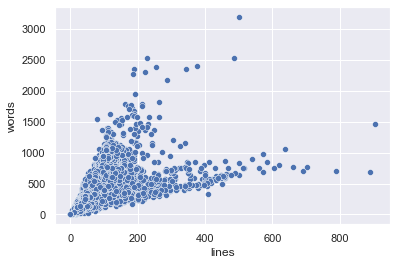

In [96]:
sns.scatterplot(data=df, x='lines', y='words')

In [ ]:
TO DO
- split scans into columns, stats per column
- cluster on similarity to neighbours

In [135]:
from collections import Counter

from pagexml.analysis.text_stats import get_words_per_line

scans = read_pagexml_docs_from_line_file(na_line_file, add_bounding_box=True)

wpl_scans = Counter()

for si, scan in enumerate(scans):
    wpl_scan = get_words_per_line(scan)
    for wpl in wpl_scan:
        wpl_scans[wpl] += wpl_scan[wpl]
    if (si+1) >= 500:
        break
    
wpl_scans

Counter({'3-3': 1406,
         '6-9': 10645,
         '4-5': 3067,
         '1-1': 4122,
         '2-2': 1886,
         '10-15': 4036,
         '0-0': 479,
         '16-25': 92})

In [134]:
import numpy as np

wpl_to_cat = {}
wpl_cat_min = {}
wpl_cat_max = {}

for wpl in range(0, 101):
    print(wpl, (np.log(wpl) * 2).round(0) / 2, np.exp((np.log(wpl) * 2).round(0) / 2))
    wpl_cat = (np.log(wpl) * 2).round(0) / 2
    wpl_to_cat[wpl] = wpl_cat
    if wpl_cat not in wpl_cat_min:
        wpl_cat_min[wpl_cat] = wpl
    wpl_cat_max[wpl_cat] = wpl


0 -inf 0.0
1 0.0 1.0
2 0.5 1.6487212707001282
3 1.0 2.718281828459045
4 1.5 4.4816890703380645
5 1.5 4.4816890703380645
6 2.0 7.38905609893065
7 2.0 7.38905609893065
8 2.0 7.38905609893065
9 2.0 7.38905609893065
10 2.5 12.182493960703473
11 2.5 12.182493960703473
12 2.5 12.182493960703473
13 2.5 12.182493960703473
14 2.5 12.182493960703473
15 2.5 12.182493960703473
16 3.0 20.085536923187668
17 3.0 20.085536923187668
18 3.0 20.085536923187668
19 3.0 20.085536923187668
20 3.0 20.085536923187668
21 3.0 20.085536923187668
22 3.0 20.085536923187668
23 3.0 20.085536923187668
24 3.0 20.085536923187668
25 3.0 20.085536923187668
26 3.5 33.11545195869231
27 3.5 33.11545195869231
28 3.5 33.11545195869231
29 3.5 33.11545195869231
30 3.5 33.11545195869231
31 3.5 33.11545195869231
32 3.5 33.11545195869231
33 3.5 33.11545195869231
34 3.5 33.11545195869231
35 3.5 33.11545195869231
36 3.5 33.11545195869231
37 3.5 33.11545195869231
38 3.5 33.11545195869231
39 3.5 33.11545195869231
40 3.5 33.115451958692

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_66535/612245010.py:8: RuntimeWarning: divide by zero encountered in log
  print(wpl, (np.log(wpl) * 2).round(0) / 2, np.exp((np.log(wpl) * 2).round(0) / 2))
/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_66535/612245010.py:9: RuntimeWarning: divide by zero encountered in log
  wpl_cat = (np.log(wpl) * 2).round(0) / 2


In [130]:
wpl_to_cat
wpl_cat_min, wpl_cat_max
wpl_cat_range = {wpl_cat: f"{wpl_cat_min[wpl_cat]}-{wpl_cat_max[wpl_cat]}" for wpl_cat in wpl_cat_min}
wpl_cat_range

{-inf: '0-0',
 0.0: '1-1',
 0.5: '2-2',
 1.0: '3-3',
 1.5: '4-5',
 2.0: '6-9',
 2.5: '10-15',
 3.0: '16-25',
 3.5: '26-42',
 4.0: '43-70',
 4.5: '71-100'}

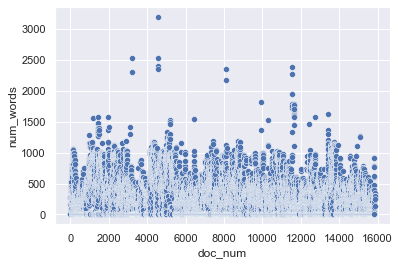

In [40]:
import seaborn as sns

sns.scatterplot(data=df, x='doc_num', y='num_words');

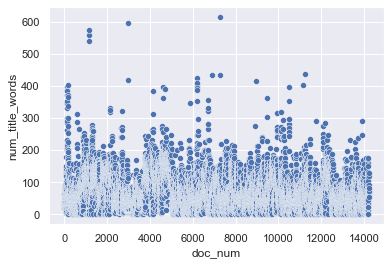

In [67]:
sns.scatterplot(data=df, x='doc_num', y='num_title_words');

## Analysing individual inventories

In [69]:
df.inv_num.value_counts()

44       632
1167     565
45       446
1166     399
1182     376
        ... 
1365       1
946        1
1360A      1
907        1
246        1
Name: inv_num, Length: 533, dtype: int64

In [70]:
inv_44 = df[df.inv_num == '44']

inv_44.describe()

,doc_num,lines,words,text_regions,columns,extra,pages,num_words,num_number_words,num_title_words,...,num_words_length_15,num_words_length_20,num_words_length_25,num_words_length_30,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,scan_num
count,632.000000,632.000000,632.000000,632.000000,632.0,632.0,632.0,632.000000,632.000000,632.000000,...,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,8274.500000,63.420886,410.425633,2.541139,0.0,0.0,0.0,410.840190,3.968354,59.718354,...,26.731013,1.011076,0.011076,0.003165,6.517405,0.973101,16.487342,7.452532,31.990506,336.681962
std,182.586966,25.004533,199.018752,1.255688,0.0,0.0,0.0,198.962805,4.870326,33.705865,...,14.954038,1.335201,0.104741,0.056210,6.556086,1.413397,25.900514,17.451975,27.090385,191.771569
min,7959.000000,1.000000,2.000000,1.000000,0.0,0.0,0.0,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,8116.750000,52.000000,298.000000,2.000000,0.0,0.0,0.0,298.750000,1.000000,36.000000,...,17.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,171.750000
50%,8274.500000,66.000000,372.000000,2.000000,0.0,0.0,0.0,372.500000,2.000000,51.500000,...,24.000000,1.000000,0.000000,0.000000,5.000000,1.000000,3.000000,1.000000,32.000000,335.500000
75%,8432.250000,76.000000,536.250000,3.000000,0.0,0.0,0.0,536.250000,5.000000,76.000000,...,34.000000,1.000000,0.000000,0.000000,8.000000,1.000000,15.000000,4.000000,54.000000,500.250000
max,8590.000000,141.000000,964.000000,11.000000,0.0,0.0,0.0,964.000000,39.000000,163.000000,...,87.000000,9.000000,1.000000,1.000000,45.000000,13.000000,102.000000,106.000000,81.000000,670.000000


### Book section detection
<a id='section_detection'></a>

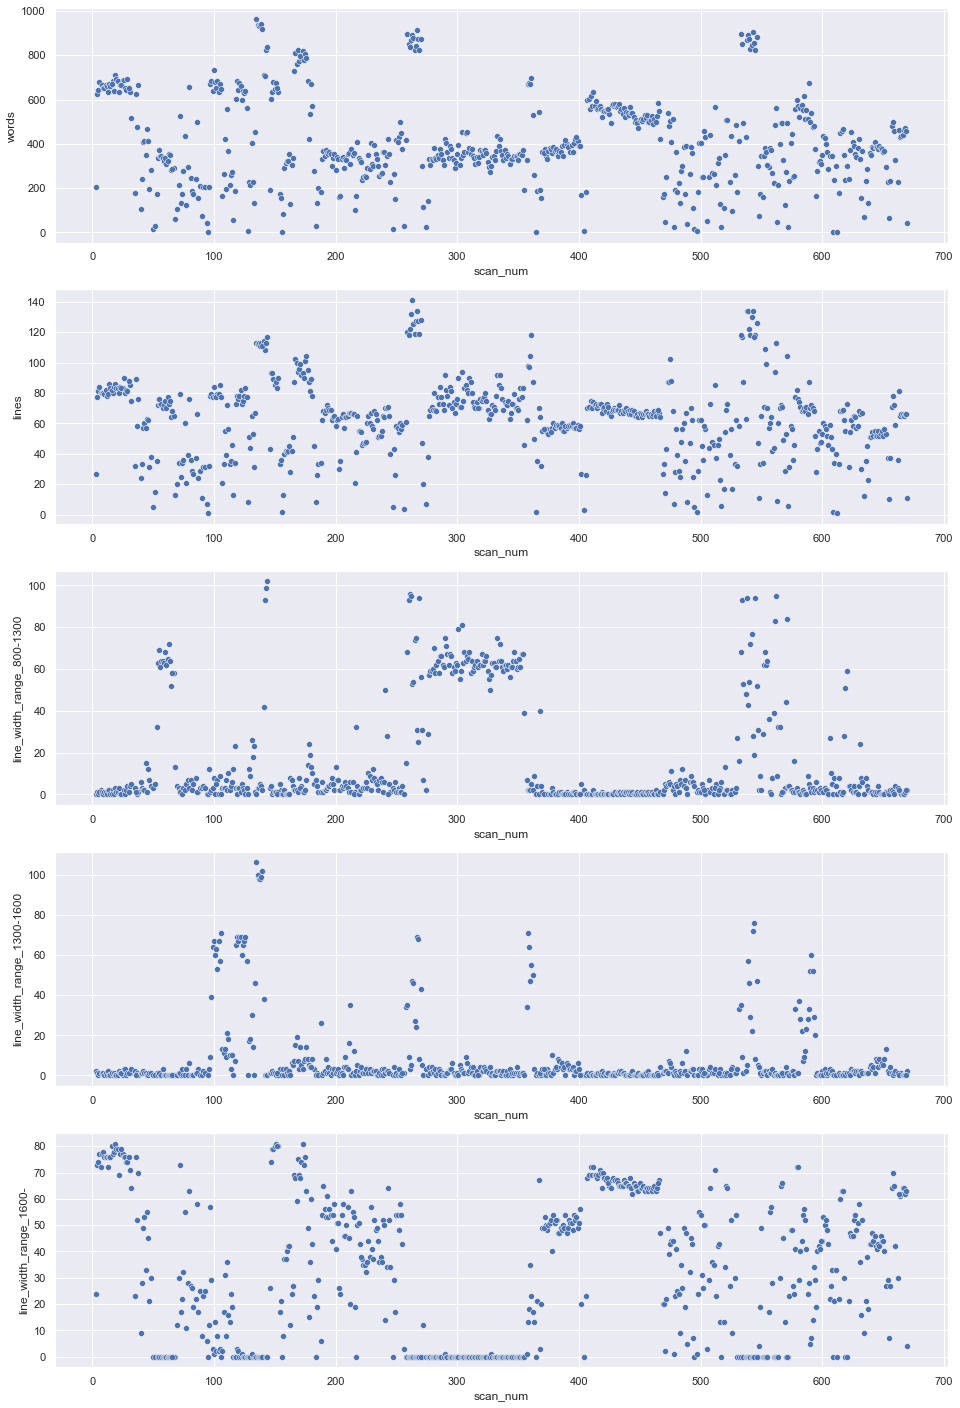

In [71]:
import matplotlib.pyplot as plt

fields = [
    'words', 'lines', 
    #'num_number_words', 
    'line_width_range_800-1300', 
    'line_width_range_1300-1600', 
    'line_width_range_1600-'
]

fig, ax = plt.subplots(len(fields), 1)

for fi, field in enumerate(fields):
    sns.scatterplot(data=inv_44, x='scan_num', y=field, ax=ax[fi])

fig.set_size_inches(16,5*len(fields))

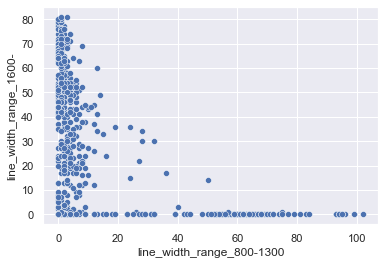

In [72]:
sns.scatterplot(data=inv_44, x='line_width_range_800-1300', y='line_width_range_1600-');

The two categories of line widths are almost mutually exclusive. Scans with at least some lines between 800 and 1300 pixels tend to have _no_ lines wider than 1600 pixels.

In [137]:
inv_44[(inv_44.scan_num > 280) & (inv_44.scan_num < 340)][['doc_id', 'iiif_url']].style.format({'iiif_url': make_clickable})


,doc_id,iiif_url
9164,NL-HaNA_1.05.06_44_0281.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0281?eadId=1.05.06&unitID=44
9165,NL-HaNA_1.05.06_44_0282.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0282?eadId=1.05.06&unitID=44
9166,NL-HaNA_1.05.06_44_0283.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0283?eadId=1.05.06&unitID=44
9167,NL-HaNA_1.05.06_44_0284.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0284?eadId=1.05.06&unitID=44
9168,NL-HaNA_1.05.06_44_0285.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0285?eadId=1.05.06&unitID=44
9169,NL-HaNA_1.05.06_44_0286.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0286?eadId=1.05.06&unitID=44
9170,NL-HaNA_1.05.06_44_0288.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0288?eadId=1.05.06&unitID=44
9171,NL-HaNA_1.05.06_44_0287.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0287?eadId=1.05.06&unitID=44
9172,NL-HaNA_1.05.06_44_0289.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0289?eadId=1.05.06&unitID=44
9173,NL-HaNA_1.05.06_44_0290.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0290?eadId=1.05.06&unitID=44


In [73]:
word_cols = [
    'num_words', 'num_number_words', 'num_title_words',
    'num_non_title_words', 'num_stop_words', 'num_punctuation_words',
    'num_oversized_words', 'num_words_length_5', 'num_words_length_10',
    'num_words_length_15', 'num_words_length_20', 'num_words_length_25'
]

word_rel_df = df[word_cols].div(df.num_words, axis=0)
word_rel_df

,num_words,num_number_words,num_title_words,num_non_title_words,num_stop_words,num_punctuation_words,num_oversized_words,num_words_length_5,num_words_length_10,num_words_length_15,num_words_length_20,num_words_length_25
0,1.0,0.006061,0.375758,0.624242,NaN,0.000000,0.0,0.539394,0.357576,0.103030,0.0,0.0
1,1.0,0.000000,0.073427,0.926573,NaN,0.000000,0.0,0.472028,0.468531,0.059441,0.0,0.0
2,1.0,0.000000,0.106464,0.893536,NaN,0.000000,0.0,0.509506,0.391635,0.098859,0.0,0.0
3,1.0,0.007843,0.152941,0.847059,NaN,0.003922,0.0,0.678431,0.282353,0.035294,0.0,0.0
4,1.0,0.015385,0.167308,0.832692,NaN,0.001923,0.0,0.665385,0.273077,0.059615,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14212,1.0,0.011278,0.263158,0.736842,NaN,0.003759,0.0,0.590226,0.353383,0.052632,0.0,0.0
14213,1.0,0.013468,0.239057,0.760943,NaN,0.003367,0.0,0.572391,0.353535,0.074074,0.0,0.0
14214,1.0,0.013793,0.251724,0.748276,NaN,0.000000,0.0,0.582759,0.320690,0.096552,0.0,0.0
14215,1.0,0.023810,0.325397,0.674603,NaN,0.000000,0.0,0.523810,0.412698,0.063492,0.0,0.0


In [74]:
word_cat = 'num_words_length_15'
rel_df.sort_values(word_cat, ascending=False)[['doc_id', 'doc_num', 'num_words', word_cat]]

KeyError: "['doc_id', 'doc_num'] not in index"

In [166]:
word_cat = 'num_number_words'
rel_df.sort_values(word_cat, ascending=False)[['doc_id', 'doc_num', 'num_words', word_cat]]


,doc_id,doc_num,num_words,num_number_words
244,NL-AsnDA_0114.11_1_0245.jpg,245,8,0.750000
298,NL-AsnDA_0114.11_1_0300.jpg,299,235,0.178723
73,NL-AsnDA_0114.11_1_0073.jpg,74,524,0.146947
380,NL-AsnDA_0114.11_1_0382.jpg,381,423,0.144208
322,NL-AsnDA_0114.11_1_0324.jpg,323,21,0.142857
...,...,...,...,...
572,NL-AsnDA_0114.11_1_0574.jpg,573,0,NaN
599,NL-AsnDA_0114.11_1_0601.jpg,600,0,NaN
624,NL-AsnDA_0114.11_1_0627.jpg,625,0,NaN
628,NL-AsnDA_0114.11_1_0630.jpg,629,0,NaN


In [167]:
word_cat = 'num_title_words'
rel_df.sort_values(word_cat, ascending=False)[['doc_id', 'doc_num', 'num_words', word_cat]]


,doc_id,doc_num,num_words,num_title_words
469,NL-AsnDA_0114.11_1_0470.jpg,470,22,0.409091
613,NL-AsnDA_0114.11_1_0614.jpg,614,309,0.355987
103,NL-AsnDA_0114.11_1_0104.jpg,104,292,0.345890
423,NL-AsnDA_0114.11_1_0424.jpg,424,268,0.339552
52,NL-AsnDA_0114.11_1_0053.jpg,53,232,0.323276
...,...,...,...,...
572,NL-AsnDA_0114.11_1_0574.jpg,573,0,NaN
599,NL-AsnDA_0114.11_1_0601.jpg,600,0,NaN
624,NL-AsnDA_0114.11_1_0627.jpg,625,0,NaN
628,NL-AsnDA_0114.11_1_0630.jpg,629,0,NaN


<AxesSubplot:xlabel='doc_num', ylabel='num_title_words'>

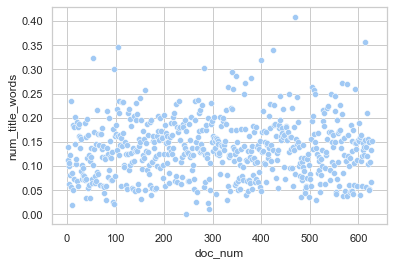

In [164]:
sns.scatterplot(data=rel_df, x='doc_num', y='num_title_words')

In [157]:
title_doc_ids =  set(rel_df[rel_df.num_title_words > 0.3].doc_id)

for scan in scans:
    if scan.id in title_doc_ids:
        print(scan.id)
        for line in scan.get_lines():
            if line.text is None:
                continue
            print('\t', line.text)
        print('\n')
            
            
title_doc_ids

NL-AsnDA_0114.11_1_0053.jpg
	 soo negen
	 5
	 8
	 3
	 1688
	 18
	 7
	 n
	 d
	 2
	 leden den Achtien Mei Achttien
	 honderd Negen en Negentig
	 enhenen voor mj Diederik Anne
	 nane de Trenny notaris ter stindperat
	 Ansen, arrondissement Asen, in tegenwoordigheid
	 der beide natenoemen getuigen.
	 Mijnhuur Aaltien strabling, zonder kroep
	 wonende te soen, weduwe van den den Willem
	 erdons Andiene
	 de Heer Petrus Hermannen Hleema van
	 sael, vandidaat notaris, wonende te Aen
	 en gemaertig van
	 =denthen Oetus Jacobus Andréae, ot alhonder
	 onende te Aen
	 Mejnfouw AAnna Elisabeth Andreae.
	 rorden kwijn wonende te Assen, nedume van
	 den Heer Haarlus Wijdorge
	 = Mijnpouw Aaltje Margaretha Andréae
	 zonden beroep wonende te Eolingels, manue van
	 den Heer Evert Guirink
	 —
	 de den Heer Albertus Hendrikus Kolkers,
	 zonder beroep wonende te Amsterdom, wedeuw
	 naar van Mejuffrouw Helma Annechien
	 ntreal met nie hij in algeheele gemeen
	 shap van goederen was gekuwd.
	 e den Heer Con

{'NL-AsnDA_0114.11_1_0053.jpg',
 'NL-AsnDA_0114.11_1_0097.jpg',
 'NL-AsnDA_0114.11_1_0104.jpg',
 'NL-AsnDA_0114.11_1_0284.jpg',
 'NL-AsnDA_0114.11_1_0400.jpg',
 'NL-AsnDA_0114.11_1_0424.jpg',
 'NL-AsnDA_0114.11_1_0470.jpg',
 'NL-AsnDA_0114.11_1_0614.jpg'}

In [172]:
from pagexml.helper.pagexml_helper import pretty_print_textregion

selected_doc_ids =  set(df[df.num_number_words > 70].doc_id)

for scan in scans:
    if scan.id in selected_doc_ids:
        print(scan.id)
        pretty_print_textregion(scan)
        print('\n')
            
            

selected_doc_ids

NL-AsnDA_0114.11_1_0023.jpg
 door der

 Goederen

 nuard

  em

  hoe

  jem

  idem

  am

  am

  am

  min

  am

  cem

  um

  um

  hul

 wiphar

 weegen

 opzet

 enp

  schuuy

 iim

 een

  dem

 em

  iem

 den

 reen

 ee

 een

 idem

 reen

 een

 dem

 een

 en

 den

 dem

 eem

 ren

 en

 een

 eeen

        die in en maand October nansteende met

        heitnud zal dubel stuivergeld verschuldigd zijn

                                                             schuw
        Navoorlezing van vorenstaande voor

                                                              am
         waarden heeft de verkoop plaats gehad en is ver
                                                             um
        kocht als nolgt

                                                             rm

                                                              cum

     eamen der
                    woon
                                 Koopom in
                                       

 zeven gulden vijftig cent
 twee gulem
 twee gulden
 twee gulden dertig cent
 drie gulden vijf en twintig cent
 twee gulden tien cent
 acht gulden vyf en twintig cent
 negen gulden vijftig cnt
 tien gulden vijftig cent
 een gulden vijftig cent
 twee gulden veertig cent
 twee gulden veertig ent
 elf gulden
 een geleen zestig cent
 twintig gulden
 acht geleen
 even gulden
 een gulden vijf en zevintig cent
 een guleen
 vier gulden vijf en twintig cent
 vier gulden
 vier gulden
 ij gulden
 vijftig cent
 vyftig cent
 twintigeent
 twee guleen
 twee gulden vijftig cent
 dertien gulden
 vier gulden
 vier gulden vijf en twintig cent
 twaalf gulden vijf en twintig cent
 twaalf gulden vyf en zeventig cent
 twee gulden twintig cent
 zeven gulden vertig cent
 veertig gulden
 drie gulden vijftig cent

 28
  1
    50
   50
 20
 „

 5
 54

  2
   —
 1325
  7 50
    —
  2

    —
  2


  5
  d

  95
 1851
  150
  d
  240
 1
  1 60
 de
  8
  3
  173

    25

  7


   50
   70
  2

   50
 1
 4
   e
  4
  

                                                                                  nn
              Navoorlezing van vorenstaande voorwaarden heeft
                                                               dezelvde

                                                                                        vier gulden vig en twintig cent

                                                                                  den
                                                              dacab van veen
              de verkoop plaats gehad en is verkocht, als volgt:

                                                                                        weede gulden vijftig cent

                                                                                  een

                                                             Gereerd Schapfelmeer

                                                                                  Kloosterne vier gulden

                                       

{'NL-AsnDA_0114.11_1_0023.jpg',
 'NL-AsnDA_0114.11_1_0073.jpg',
 'NL-AsnDA_0114.11_1_0229.jpg',
 'NL-AsnDA_0114.11_1_0286.jpg',
 'NL-AsnDA_0114.11_1_0343.jpg',
 'NL-AsnDA_0114.11_1_0439.jpg',
 'NL-AsnDA_0114.11_1_0554.jpg'}

<AxesSubplot:xlabel='doc_num', ylabel='num_number_words'>

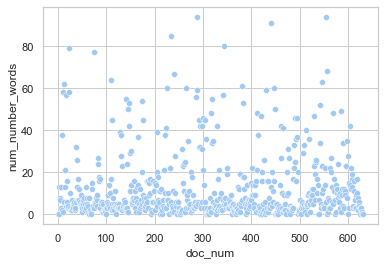

In [162]:
sns.scatterplot(data=df, x='doc_num', y='num_number_words')

<AxesSubplot:xlabel='doc_num', ylabel='lines'>

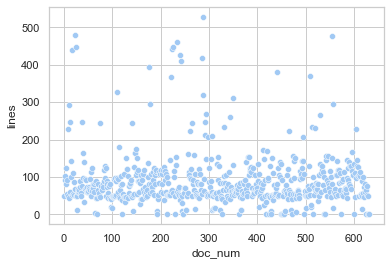

In [173]:
sns.scatterplot(data=df, x='doc_num', y='lines')

In [174]:
df.describe()

,doc_num,lines,words,text_regions,columns,extra,pages,num_words,num_number_words,num_title_words,...,num_words_length_5,num_words_length_10,num_words_length_15,num_words_length_20,num_words_length_25,num_words_length_30,line_width_range_0-1300,line_width_range_1300-1600,line_width_range_1600-2100,line_width_range_2100-
count,630.000000,630.000000,630.000000,630.000000,630.0,630.0,630.0,630.000000,630.000000,630.000000,...,630.000000,630.000000,630.000000,630.000000,630.00000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,315.500000,90.000000,379.247619,3.942857,0.0,0.0,0.0,379.247619,12.587302,47.455556,...,225.022222,131.755556,20.179365,2.198413,0.08254,0.007937,46.363492,5.585714,34.144444,0.009524
std,182.009615,74.141488,180.191760,3.037116,0.0,0.0,0.0,180.191760,16.089016,28.170451,...,111.474891,63.980004,11.540537,1.721554,0.29760,0.088803,74.301065,9.903740,20.714727,0.112373
min,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,158.250000,51.000000,279.250000,2.000000,0.0,0.0,0.0,279.250000,3.000000,29.250000,...,160.000000,99.000000,12.000000,1.000000,0.00000,0.000000,13.000000,1.000000,19.000000,0.000000
50%,315.500000,71.000000,366.500000,3.000000,0.0,0.0,0.0,366.500000,6.000000,43.500000,...,216.000000,121.000000,19.000000,2.000000,0.00000,0.000000,20.000000,2.000000,35.000000,0.000000
75%,472.750000,106.000000,502.750000,5.000000,0.0,0.0,0.0,502.750000,15.000000,62.000000,...,300.000000,172.000000,28.000000,3.000000,0.00000,0.000000,46.000000,4.000000,45.000000,0.000000
max,630.000000,528.000000,940.000000,17.000000,0.0,0.0,0.0,940.000000,94.000000,163.000000,...,618.000000,340.000000,59.000000,8.000000,3.00000,1.000000,510.000000,57.000000,86.000000,2.000000


In [177]:
for scan in scans:
    if scan.stats['words'] > 900:
        print(scan.id, scan.stats)
        #pretty_print_textregion(scan)

NL-AsnDA_0114.11_1_0175.jpg {'lines': 393, 'words': 940, 'text_regions': 4, 'columns': 0, 'extra': 0, 'pages': 0}
NL-AsnDA_0114.11_1_0286.jpg {'lines': 528, 'words': 916, 'text_regions': 7, 'columns': 0, 'extra': 0, 'pages': 0}


In [187]:
stop = False
for scan in scans:
    for tr in scan.text_regions:
        if tr.stats['lines'] > 100:
            #print(scan.id)
            #print(scan.coords.box)
            #print(tr.coords.box)
            print(tr.stats['words'], tr.stats['lines'], tr.stats['words'] / tr.stats['lines'])
            #for line in tr.get_lines():
            #    print(line.text)
            #stop = True
    if stop is True:
        break


212 113 1.8761061946902655
195 107 1.8224299065420562
298 137 2.1751824817518246
314 169 1.8579881656804733
423 229 1.8471615720524017
257 104 2.4711538461538463
282 149 1.8926174496644295
276 134 2.0597014925373136
257 148 1.7364864864864864
450 192 2.34375
303 126 2.4047619047619047
315 164 1.920731707317073
266 118 2.2542372881355934
451 173 2.606936416184971
452 184 2.4565217391304346
448 236 1.8983050847457628
297 112 2.6517857142857144
322 141 2.2836879432624113
360 182 1.978021978021978
280 133 2.1052631578947367
336 146 2.3013698630136985
169 123 1.3739837398373984
173 101 1.7128712871287128
233 101 2.3069306930693068
769 205 3.7512195121951217
212 125 1.696
348 151 2.3046357615894038
320 153 2.0915032679738563
423 231 1.8311688311688312
277 155 1.7870967741935484
230 129 1.7829457364341086
327 137 2.386861313868613
735 307 2.3941368078175898
249 125 1.992
318 124 2.564516129032258
286 105 2.723809523809524
298 133 2.2406015037593985
452 101 4.475247524752476
548 161 3.40372670

In [79]:
import os, tempfile
tmp = tempfile.NamedTemporaryFile(delete=False)
try:
    print(tmp.name)
    tmp.write(b'bla')
finally:
    tmp.close()
    os.unlink(tmp.name)

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/tmp48ibgr1i


In [174]:
def tr_reader(scans):
    for scan in scans:
        for tr in scan.text_regions:
            yield tr
            
trs_stats = []

scans = parse_pagexml_files_from_archive(da_archive_file)

trs_stats = get_doc_stats(tr_reader(scans), line_width_boundary_points=boundary_points)
trs_stats

keys = [key for key in trs_stats.keys()]
for key in keys:
    if len(trs_stats[key]) == 0:
        del trs_stats[key]


In [176]:
tr_df = pd.DataFrame(trs_stats)
tr_df.shape

tr_df

,doc_id,doc_num,doc_width,doc_height,lines,words,text_regions,num_words,num_number_words,num_title_words,...,num_words_length_10,num_words_length_15,num_words_length_20,num_words_length_25,num_words_length_30,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-
0,r1,1,374,160,1,2,0,2,0,1,...,1,0,0,0,0,1,0,0,0,0
1,r2,2,98,520,2,2,0,2,0,0,...,0,0,0,0,0,2,0,0,0,0
2,r3,3,1824,3498,46,302,0,302,0,42,...,116,21,0,0,0,3,1,2,2,38
3,r1,4,1828,3497,45,284,0,284,0,33,...,118,13,0,0,0,6,2,2,0,35
4,r2,5,346,156,1,2,0,2,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2479,r3,2480,1924,3437,40,213,0,213,1,29,...,78,16,1,0,0,4,3,3,3,27
2480,r1,2481,1936,3228,38,247,0,247,2,2,...,75,23,1,1,0,2,2,0,1,33
2481,r2,2482,1978,3510,39,207,0,207,1,28,...,60,22,2,0,0,3,6,4,2,23
2482,r1,2483,168,156,1,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
